In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
import sys
import random
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
import pickle
import sys
import networkx as nx
from definitions import get_node_color, get_node_id
sys.path.append("./..")
from bi_graph import BiGraph
from population_graph import Population_Graph
from utils import PROJECT_ROOT


# Load single cell Data and clinical data

In [2]:
# read single cell data and clinical data
cells = pd.read_csv(os.path.join(PROJECT_ROOT, "Datasets/Danenberg_et_al/cells.csv"))
clinical = pd.read_csv(
    os.path.join(PROJECT_ROOT, "Datasets/Danenberg_et_al/clinical.csv")
)
print("Initially,")
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove images without invasive tumor
print("\nRemove images without invasive tumor,")
cells = cells.loc[cells.isTumour == 1]
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
        len(clinical["metabric_id"].unique()),
    )
)
# remove patients with no clinical data
print("\nRemove patients with no clinical data,")
cells = cells.loc[cells["metabric_id"].isin(clinical["metabric_id"])]
print(
    "{} patients ({} images) with cell data and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)
# remove images with less than 500 cells
print("\nRemove images with less than 500 cells")
cells_per_image = cells.groupby("ImageNumber").size()
cells = cells.loc[
    cells["ImageNumber"].isin(cells_per_image[cells_per_image > 500].index)
]
clinical = clinical.loc[clinical["metabric_id"].isin(cells["metabric_id"].unique())]
print(
    "{} patients ({} images) with more than 500 cells and clinical data, ".format(
        len(cells["metabric_id"].unique()),
        len(cells["ImageNumber"].unique()),
    )
)

random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical["Subset_id"] = Subset_id
cells_discovery = cells.loc[
    cells["metabric_id"].isin(clinical.loc[clinical["Subset_id"] == 1, "metabric_id"])
]
cells_validation = cells.loc[
    cells["metabric_id"].isin(clinical.loc[clinical["Subset_id"] == 2, "metabric_id"])
]
print("\nAfter splitting into discovery and validation sets,")
print(
    "{} patients ({} images) with more than 500 cells and clinical data in the discovery set, ".format(
        len(cells_discovery["metabric_id"].unique()),
        len(cells_discovery["ImageNumber"].unique()),
    )
)

Initially,
718 patients (794 images) with cell data, 2604 patients with clinical data, 

Remove images without invasive tumor,
693 patients (749 images) with cell data, 2604 patients with clinical data, 

Remove patients with no clinical data,
683 patients (737 images) with cell data and clinical data, 

Remove images with less than 500 cells
579 patients (621 images) with more than 500 cells and clinical data, 

After splitting into discovery and validation sets,
379 patients (404 images) with more than 500 cells and clinical data in the discovery set, 


## Standardize column names

In [3]:
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells_discovery['cellTypeID'] = cells_discovery['meta_description'].map(get_node_id('Danenberg', 'CellType') )
cells_discovery = cells_discovery.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

cells_validation['cellTypeID'] = cells_validation['meta_description'].map(get_node_id('Danenberg', 'CellType') )
cells_validation = cells_validation.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

/tmp/ipykernel_2765219/2270713344.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_discovery['cellTypeID'] = cells_discovery['meta_description'].map(get_node_id('Danenberg', 'CellType') )
/tmp/ipykernel_2765219/2270713344.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cells_validation['cellTypeID'] = cells_validation['meta_description'].map(get_node_id('Danenberg', 'CellType') )


# Fit BiGraph on discovery set

In [4]:
bigraph_ = BiGraph(k_patient_clustering = 30)
Population_graph, Patient_subgroups, _ = bigraph_.fit_transform(
    cells_discovery
)


There is a soft wl subtree kernel fitted before. We will load it directly.
If you want to re-calculate the similarity matrix, please delete the file '3_fit_wl_subtree_kernel.pkl'.
An overview of the input cellular graphs is as follows: 
	 379 unique patients.
	 32 unique cell types.
	 670335 total cells, 1768.69 cells per patient.
An overview of the identified patterns is as follows: 
	 66 discovered patterns.
Start generating population graph.
Initialized Population_Graph, k_clustering =  30 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Population graph generated.
Start detecting patient subgroups.
Patient subgroups detected.
There are 7 patient subgroups, 0 ungrouped patients
Start finding characteristic patterns for each patient subgroup.
Characteristic patterns found.


# Evaluate the hazard of each patient subgroups and reorder them

In [1]:
Patient_ids = bigraph_.Patient_ids
cph = CoxPHFitter()
lengths = [
    clinical.loc[
        clinical["metabric_id"] == i, "Disease-specific Survival (Months)"
    ].values[0]
    for i in Patient_ids
]
statuses = [
    (
        0
        if clinical.loc[
            clinical["metabric_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        == "0:LIVING"
        else 1
    )
    for i in Patient_ids
]
for i in range(len(Patient_subgroups)):
    subgroup = Patient_subgroups[i]
    patient_ids = subgroup['patient_ids']
    DF = pd.DataFrame(
        {
            "length": lengths,
            "status": statuses,
            "community": np.isin(Patient_ids, patient_ids),
        }
    )
    cph.fit(
        DF,
        duration_col="length",
        event_col="status",
        show_progress=False,
    )
    Patient_subgroups[i]["hr"] = cph.hazard_ratios_["community"]
    Patient_subgroups[i]["p"] = cph.summary["p"]["community"]
    Patient_subgroups[i]["hr_lower"] = np.exp(
                cph.confidence_intervals_["95% lower-bound"]["community"]
            )
    Patient_subgroups[i]["hr_upper"] = np.exp(
                cph.confidence_intervals_["95% upper-bound"]["community"]
            )

Patient_subgroups = sorted(Patient_subgroups, key=lambda x: x["hr"], reverse=True)
for i in range(len(Patient_subgroups)):
    Patient_subgroups[i]['subgroup_id'] = 'S'+str(i+1)
    print(
        "Patient subgroup S{}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            i + 1, len(Patient_subgroups[i]['patient_ids']), Patient_subgroups[i]["hr"], Patient_subgroups[i]["hr_lower"], Patient_subgroups[i]["hr_upper"], Patient_subgroups[i]["p"]
        )
    )


NameError: name 'bigraph_' is not defined

# Plot Population graph (Fig.6.a)

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


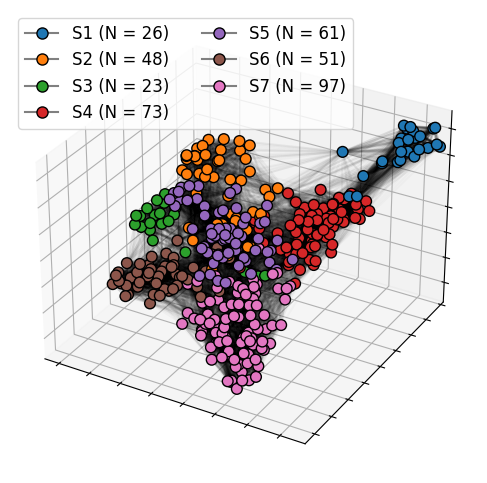

In [9]:
Subgroup_ids = np.zeros(len(Patient_ids), dtype=object)
Subgroup_ids[:] = "Unclassified"
for i in range(len(Patient_subgroups)):
    subgroup = Patient_subgroups[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    Subgroup_ids[np.isin(Patient_ids, patient_ids)] = subgroup_id
color_palette = {
    "Unclassified": "white",
    "S1": sns.color_palette("tab10")[0],
    "S2": sns.color_palette("tab10")[1],
    "S3": sns.color_palette("tab10")[2],
    "S4": sns.color_palette("tab10")[3],
    "S5": sns.color_palette("tab10")[4],
    "S6": sns.color_palette("tab10")[5],
    "S7": sns.color_palette("tab10")[6],
    "S8": sns.color_palette("tab10")[7],
    "S9": sns.color_palette("tab10")[8],
    "S10": sns.color_palette("tab10")[9],
}
# For visualization purpose, we make nodes distant from each other
Population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, Patient_ids
)  # generate population graph
pos = nx.spring_layout(
    Population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(Population_graph)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in Population_graph.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[i] for i in Subgroup_ids],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(Population_graph.edges())
edge_alpha = [
    (
        0.2 * Population_graph[u][v]["weight"]
        if Population_graph[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
if np.sum(Subgroup_ids == "Unclassified") > 0:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="white",
            markerfacecolor="white",
            label="Unclassified (N = {})".format(
                np.sum(Subgroup_ids == "Unclassified")
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )
for subgroup in Patient_subgroups:
    subgroup_id = subgroup["subgroup_id"]
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette[subgroup_id],
            label="{} (N = {})".format(
                subgroup_id, np.sum(Subgroup_ids == subgroup_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=12, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


# Plot Survival curves (Fig.6.b)

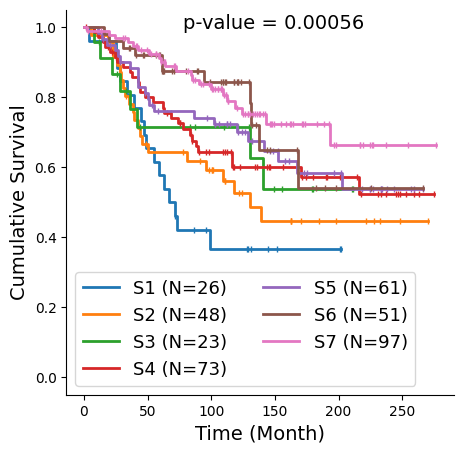

In [10]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5,5))
for subgroup in Patient_subgroups:
    subgroup_id = subgroup["subgroup_id"]
    length_A, event_observed_A = (
        np.array(lengths)[Subgroup_ids == subgroup_id],
        np.array(statuses)[Subgroup_ids == subgroup_id],
    )
    label = "{} (N={})".format(
        subgroup["subgroup_id"], np.sum(Subgroup_ids == subgroup_id)
    )
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[subgroup_id],
        show_censors=True,
        linewidth=2,
        censor_styles={"ms": 5, "marker": "|"},
    )
log_rank_test = multivariate_logrank_test(
    np.array(lengths)[Subgroup_ids != 0],
    np.array(Subgroup_ids)[Subgroup_ids != 0],
    np.array(statuses)[Subgroup_ids != 0],
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize=13)
ax.text(
    x=0.3,
    y=0.95,
    s="p-value = {:.5f}".format(p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

# Plot hazard ratios (Fig.6.c )

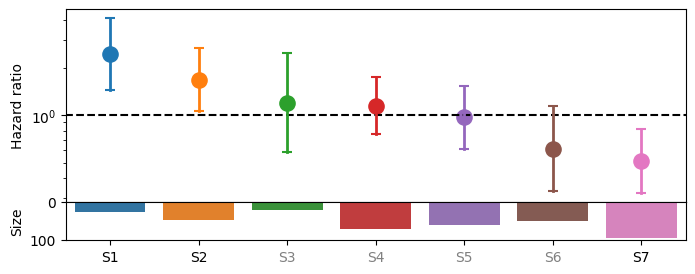

In [11]:
# Plot hazard ratio
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(Patient_subgroups), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(Patient_subgroups)):
    subgroup = Patient_subgroups[i]
    subgroup_id = subgroup['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            subgroup["hr"],
            subgroup["hr_lower"],
            subgroup["hr_upper"],
            subgroup["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[subgroup_id], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[subgroup_id], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[subgroup_id], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[subgroup_id], s=60, marker="_")
    N.append(np.sum(Subgroup_ids == subgroup_id))
    xticklabels.append("{}".format(subgroup_id))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(Patient_subgroups)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()